[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-12-22  195.179993  195.410004  192.970001  193.600006  193.353287   
2023-12-26  193.610001  193.889999  192.830002  193.050003  192.803986   
2023-12-27  192.490005  193.500000  191.089996  193.149994  192.903839   
2023-12-28  194.139999  194.660004  193.169998  193.580002  193.333298   
2023-12-29  193.899994  194.399994  191.729996  192.529999  192.284637   

              Volume  
Date                  
2023-12-22  37122800  
2023-12-26  28919300  
2023-12-27  48087700  
2023-12-28  34049900  
2023-12-29  42628800  
              Open         High          Low        Close    Adj Close  \
count  6037.000000  6037.000000  6037.000000  6037.000000  6037.000000   
mean     35.836839    36.227569    35.461397    35.861158    34.509795   
std      51.002750    51.568311    50.478962    51.050850    50.786127   
min       0.231964     0

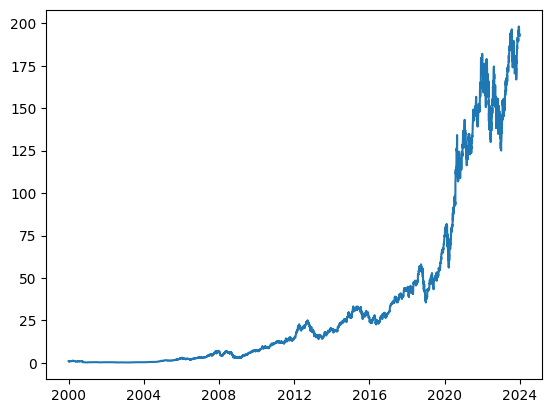

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt

df = yf.download("AAPL", start='2000-01-03', end='2023-12-30')

print(df.tail())
print(df.describe())

plt.plot(df['Close'])

[*********************100%%**********************]  3 of 3 completed

Ticker          AAPL        FE        WMT
Date                                     
2000-01-03  0.846127  7.440518  14.419449
2000-01-04  0.774790  7.440518  13.879905
2000-01-05  0.786128  7.714530  13.596634
2000-01-06  0.718097  7.735610  13.745015
2000-01-07  0.752113  7.777763  14.783645
Ticker            AAPL         FE        WMT
Date                                        
2023-12-22  193.353287  35.819885  51.859924
2023-12-26  192.803986  35.928642  51.780468
2023-12-27  192.903839  35.908867  52.267124
2023-12-28  193.333298  36.175812  52.164497
2023-12-29  192.284637  36.245018  52.190979
Ticker         AAPL           FE          WMT
count   6037.000000  6037.000000  6037.000000
mean      34.509795    24.472175    21.106066
std       50.786127     8.310898    12.374883
min        0.198346     6.235915     9.366558
25%        1.837121    19.758533    11.832490
50%       12.349164    24.212019    15.025212
75%       39.221970    30.020031    25.846237
max      197.857529    

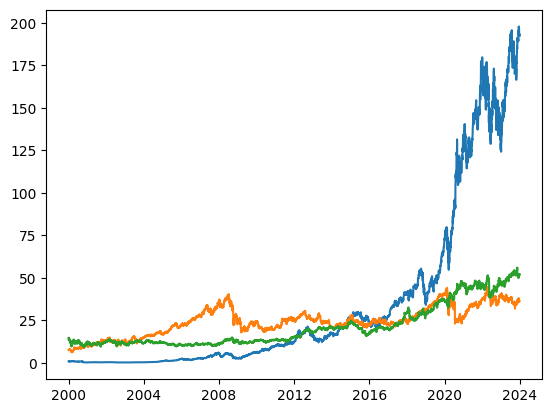

In [3]:
stocks = ['AAPL', 'FE', 'WMT']

stock_prices = yf.download(stocks, start='2000-01-03', end='2023-12-30')['Adj Close']

print(stock_prices.head())
print(stock_prices.tail())
print(stock_prices.describe())

plt.plot(stock_prices)

Ticker          AAPL        FE       WMT
Date                                    
2000-01-04  0.915690  1.000000  0.962582
2000-01-05  0.929089  1.036827  0.942937
2000-01-06  0.848687  1.039660  0.953227
2000-01-07  0.888889  1.045326  1.025257
2000-01-10  0.873255  1.048159  1.006548
Ticker          AAPL        FE       WMT
Date                                    
2000-01-04 -0.084310  0.000000 -0.037418
2000-01-05  0.014633  0.036827 -0.020409
2000-01-06 -0.086538  0.002732  0.010913
2000-01-07  0.047369  0.005449  0.075564
2000-01-10 -0.017588  0.002710 -0.018248
Ticker
AAPL    7.352462
FE      2.389603
WMT     1.949258
dtype: float64


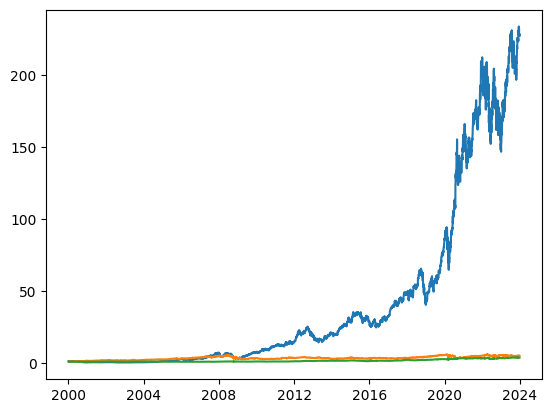

In [4]:
stock_returns = stock_prices.pct_change().dropna()
stock_returns_cumulative = (1 + stock_returns).cumprod()

print(stock_returns_cumulative.head())
print(stock_returns.head())
print(stock_returns.sum())
plt.plot(stock_returns_cumulative)



In [5]:
# Get risk free rate - T-Bills
import pandas_datareader as pdr
 
rf = pdr.DataReader('TB3MS', 'fred', start='2000-01-01', end='2023-12-30')
# Result as %, so 5% is represented as 5
print(rf.head())

# SPY as market proxy
mkt_prices = yf.download('SPY', start='2000-01-03', end='2023-12-30')['Adj Close']
print(mkt_prices.head())

            TB3MS
DATE             
2000-01-01   5.32
2000-02-01   5.55
2000-03-01   5.69
2000-04-01   5.66
2000-05-01   5.79


[*********************100%%**********************]  1 of 1 completed

Date
2000-01-03    93.591141
2000-01-04    89.931168
2000-01-05    90.092018
2000-01-06    88.644135
2000-01-07    93.792221
Name: Adj Close, dtype: float64


In [ ]:
import statsmodels.api as sm

# Resample to monthly, to match T-Bill data
stock_prices_monthly = stock_prices.resample('MS').first()
mkt_prices_monthly = mkt_prices.resample('MS').first()

aapl_returns_monthly = stock_prices_monthly['AAPL'].pct_change()
mkt_returns_monthly = mkt_prices_monthly.pct_change()
# Divide the risk-free rate by 100 and then by 12 to convert it 
# from an annual percentage to a monthly decimal value.
y = (aapl_returns_monthly - rf['TB3MS']/100/12).dropna()
X = (mkt_returns_monthly - rf['TB3MS']/100/12).dropna()
# To perform the regression, first we describe the regression model by 
# defining the data used for the dependent variable on the left side of the regression, 
# y, and the independent variable(s) on the right-hand side, X.
model = sm.OLS(y,X)
results = model.fit()
# x1 in the result is the beta of the stock (AAPL) to the market (SPY)
print(results.summary())
print()

rf_last = rf['TB3MS'].iloc[-1]/100
mkt_avg = mkt_returns_monthly.mean()*12
beta = results.params['x1']

print('The current risk-free rate is', rf_last*100,'%')
# Expected market return
print('The avg annualized market return is', mkt_avg*100, '%')

exp_ret = rf_last + beta*(mkt_avg - rf_last)
print('The expected return of the stock is', exp_ret*100, '%')

In [30]:
def calculate_exp_ret(stock, market, rf):
    rf_monthly = rf['TB3MS']/100/12
    y = (stock - rf_monthly).dropna()
    X = (market - rf_monthly).dropna()
    model = sm.OLS(y,X)
    results = model.fit()
    beta = results.params['x1']
    rf_last = rf['TB3MS'].iloc[-1]/100
    mkt_avg = market.mean()*12
    exp_ret = rf_last + beta*(mkt_avg - rf_last)
    return exp_ret, beta

for stock in stocks:
    stock_prices_monthly = stock_prices.resample('MS').first()
    mkt_prices_monthly = mkt_prices.resample('MS').first()
    stock_returns_monthly = stock_prices_monthly[stock].pct_change()
    mkt_returns_monthly = mkt_prices_monthly.pct_change()
    exp_ret, beta = calculate_exp_ret(stock_returns_monthly, mkt_returns_monthly, rf)
    print('Stock:', stock, '\tCAPM Exp Ret:', (exp_ret*100).round(3), '%. \tBeta:', beta.round(3))
    

Stock: AAPL 	CAPM Exp Ret: 8.973 %. 	Beta: 1.317
Stock: FE 	CAPM Exp Ret: 6.085 %. 	Beta: 0.298
Stock: WMT 	CAPM Exp Ret: 6.594 %. 	Beta: 0.478
